In [ ]:
%load_ext autoreload
%autoreload 2
import os
import sys
import copy
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import abstract_gradient_training as agt
from abstract_gradient_training import AGTConfig
from abstract_gradient_training import model_utils
from labellines import *

from models.pilot_net import PilotNet
from datasets.self_driving import getSelfDrive

In [2]:
# notebook config
sns.set_style('whitegrid')
sns.set_context('poster')
palette = sns.color_palette(palette="Dark2", n_colors=12)
lb_color = list(iter(sns.color_palette(palette="deep")))[1]
ub_color = list(iter(sns.color_palette(palette="deep")))[0]

In [ ]:
pretrained_model = PilotNet()
pretrained_model.load_state_dict(torch.load(f"models/pilotnet_pretrained.ckpt"))
pretrained_model = pretrained_model.to('cuda:0')

In [4]:
batchsize = 10000
clean_batchsize = 7000
dl_clean, dl_test_clean = getSelfDrive(
    clean_batchsize, test_batchsize=5000, normalise=True, video_index=[2, 3, 4, 5, 6]
)

dl, dl_test = getSelfDrive(
    batchsize - clean_batchsize, test_batchsize=5000, normalise=True, video_index=[1],
)

In [19]:
nominal_config = AGTConfig(
    fragsize=5000,
    learning_rate=0.25,
    n_epochs=2,
    forward_bound="interval",
    device="cuda:0",
    backward_bound="interval",
    loss="mse",
    log_level="DEBUG",
    lr_decay=10.0,
    lr_min=0.001,
    early_stopping=False,
)

In [20]:
conv_layers = pretrained_model[0:11]
linear_layers = pretrained_model[11:]
conv_transform = model_utils.get_conv_model_transform(conv_layers)

In [31]:
def run_config(config):
    conf_hash = config.hash()
    fname = f".results/pilotnet_{conf_hash}.pt"
    if os.path.isfile(fname):
        return torch.load(fname)
            
    torch.manual_seed(0)
    param_l, param_n, param_u = agt.poison_certified_training(
        linear_layers, config, dl, dl_test, dl_clean=dl_clean, transform=conv_transform
    )
    torch.save((param_l, param_n, param_u), fname)
    return param_l, param_n, param_u

In [ ]:
label_k_poisons = list(range(0, 601, 50))  # full sweep
label_k_poisons = [0, 300, 600]  # reduced sweep
label_epsilons = [0.05, 0.02, 0.01]

params = {}

for epsilon in label_epsilons:
    for k_poison in label_k_poisons:
        config = copy.deepcopy(nominal_config)
        config.label_epsilon = epsilon
        config.label_k_poison = k_poison
        params[(epsilon, k_poison)] = run_config(config)


In [33]:
torch.manual_seed(0)
_, dl_test = getSelfDrive(
    100, test_batchsize=5000, normalise=True, video_index=[1], silent=True
)
batch, labels = next(iter(dl_test))

In [34]:
param_l, param_n, param_u = model_utils.get_parameters(linear_layers)
pretrained_mse = agt.test_metrics.test_mse(param_l, param_n, param_u, *next(iter(dl_test)), transform=conv_transform)[1]

In [ ]:
mses = {}

for (e, k), (param_l, param_n, param_u) in params.items():
    mses[(e, k)] = agt.test_metrics.test_mse(
        param_l, param_n, param_u, *next(iter(dl_test)), transform=conv_transform
    )
print(mses)
print(pretrained_mse)
finetuned_mse = list(mses.items())[0][1][1]
print(finetuned_mse)
for e in label_epsilons:
    mses[(e, 0)] = (finetuned_mse, finetuned_mse, finetuned_mse)

In [50]:
palette = sns.color_palette(palette="Dark2", n_colors=12)
colors = list(iter(palette))
pretrained_col = list(iter(sns.color_palette(palette="deep")))[-1]
finetuned_col = colors[2]
true_col = colors[0]

In [ ]:
sns.set_theme(context="poster", style="whitegrid", font_scale=2.0)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

fig, ax = plt.subplots(figsize=(9, 8))
colors = iter(palette)

for epsilon in label_epsilons:
    ms = [mses[(epsilon, k)][0] for k in label_k_poisons]
    ax.plot(label_k_poisons, ms, label=fr"$\nu={epsilon}$", color=next(colors))

plt.axhline(pretrained_mse, label="Pre-trained", color=pretrained_col, linestyle="-.")
plt.axhline(finetuned_mse, label="Fine-tuned", color=ub_color, linestyle="--")

plt.xlabel("Labels Poisoned $(m)$", fontsize="large")
plt.ylabel("Certified MSE", fontsize="large")
plt.legend(loc= "lower right", fontsize="small", handlelength=1.0, bbox_to_anchor=(1.03, 0.005))
plt.xlim(0, 600)
plt.ylim(0.015, 0.045)
plt.savefig(".figures/pilotnet_mse.pdf", bbox_inches='tight', dpi=300)

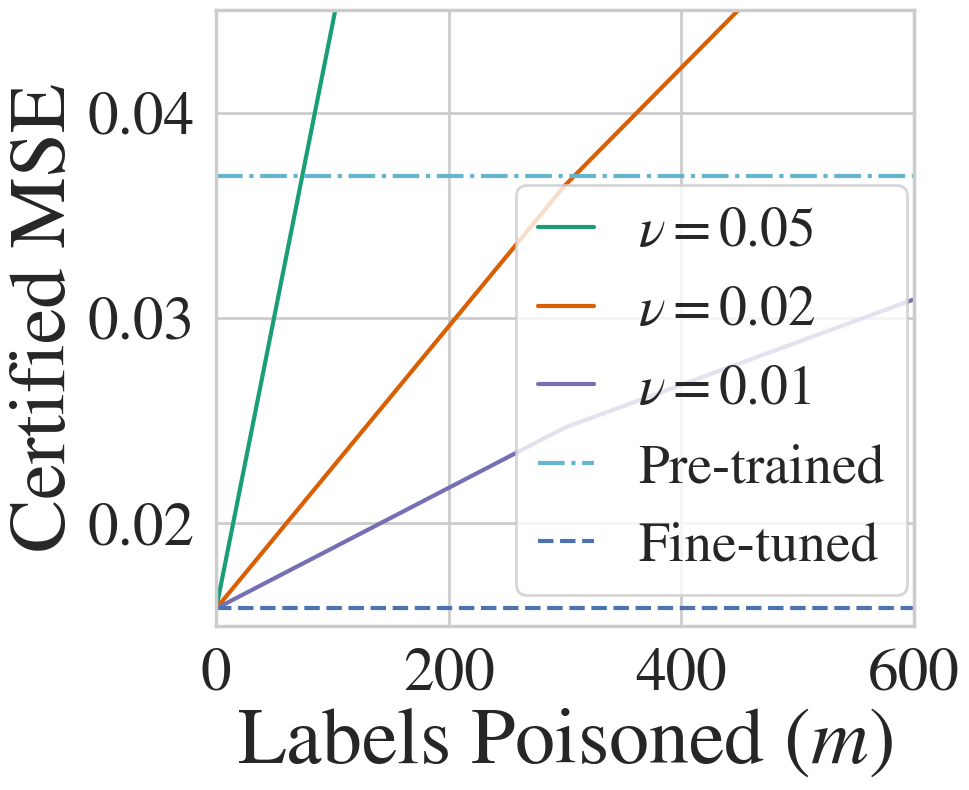